# Calculation of control fields for QFT gate on two qubits using the CRAB algorithm

Alexander Pitchford (agp1@aber.ac.uk)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
import qutip.logging_utils as logging
logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'QFT'


### Defining the physics

In [3]:
Sx = sigmax()
Sy = sigmay()
Sz = sigmaz()
Si = 0.5*identity(2)

# Drift Hamiltonian
H_d = 0.5*(tensor(Sx, Sx) + tensor(Sy, Sy) + tensor(Sz, Sz))
# The (four) control Hamiltonians
H_c = [tensor(Sx, Si), tensor(Sy, Si), tensor(Si, Sx), tensor(Si, Sy)]
n_ctrls = len(H_c)
# start point for the gate evolution
U_0 = identity(4)
# Target for the gate evolution - Quantum Fourier Transform gate
U_targ = qft.qft(2)

### Defining the time evolution parameters

In [4]:
# Number of time slots
n_ts = 200
# Time allowed for the evolution
evo_time = 10

### Set the conditions which will cause the pulse optimisation to terminate

In [5]:
# Fidelity error target
fid_err_targ = 1e-3
# Maximum iterations for the optisation algorithm
max_iter = 20000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300

### Give an extension for output files

In [6]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}.txt".format(example_name, n_ts)

### Create the optimiser objects

In [7]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                fid_err_targ=fid_err_targ, 
                max_iter=max_iter, max_wall_time=max_wall_time,
                alg='CRAB', 
                dyn_type='UNIT', 
                prop_type='DIAG', 
                fid_type='UNIT', fid_params={'phase_option':'PSU'}, 
                log_level=log_level, gen_stats=True)
                

### Configure the pulses for each of the controls

In [8]:
dyn = optim.dynamics

# Control 1
crab_pgen = optim.pulse_generator[0]
# Start from a ramped pulse
guess_pgen = pulsegen.create_pulse_gen('LIN', dyn=dyn, 
                                           pulse_params={'scaling':3.0})
crab_pgen.guess_pulse = guess_pgen.gen_pulse()
crab_pgen.scaling = 0.0
# Add some higher frequency components
crab_pgen.num_coeffs = 5

# Control 2
crab_pgen = optim.pulse_generator[1]
# Apply a ramping pulse that will force the start and end to zero
ramp_pgen = pulsegen.create_pulse_gen('GAUSSIAN_EDGE', dyn=dyn, 
                                    pulse_params={'decay_time':evo_time/50.0})
crab_pgen.ramping_pulse = ramp_pgen.gen_pulse()

# Control 3
crab_pgen = optim.pulse_generator[2]
# Add bounds
crab_pgen.scaling = 0.5
crab_pgen.lbound = -2.0
crab_pgen.ubound = 2.0


# Control 4
crab_pgen = optim.pulse_generator[3]
# Start from a triangular pulse with small signal
guess_pgen = pulsegen.PulseGenTriangle(dyn=dyn)
guess_pgen.num_waves = 1
guess_pgen.scaling = 2.0
guess_pgen.offset = 2.0
crab_pgen.guess_pulse = guess_pgen.gen_pulse()
crab_pgen.scaling = 0.1

init_amps = np.zeros([n_ts, n_ctrls])
for j in range(dyn.num_ctrls):
    pgen = optim.pulse_generator[j]
    pgen.init_pulse()
    init_amps[:, j] = pgen.gen_pulse()

dyn.initialize_controls(init_amps)

INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 3, which means a total of 6 optimisation variables for this pulse. Based on the dimension (4) of the system
INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 3, which means a total of 6 optimisation variables for this pulse. Based on the dimension (4) of the system
INFO:qutip.control.pulsegen:The number of CRAB coefficients per basis function has been estimated as 3, which means a total of 6 optimisation variables for this pulse. Based on the dimension (4) of the system
INFO:qutip.control.dynamics:Internal operator data type choosen to be <class 'numpy.ndarray'>


### Run the pulse optimisation

In [9]:
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("Starting pulse optimisation")
result = optim.run_optimization()

# Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)

INFO:qutip.control.optimizer:Optimising pulse(s) using CRAB with 'fmin' (Nelder-Mead) method


Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts200.txt
***********************************
Starting pulse optimisation
Final amplitudes output to file: ctrl_amps_final_QFT_n_ts200.txt


### Report the results

In [11]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Initial fidelity error {}".format(result.initial_fid_err))
print("Final fidelity error {}".format(result.fid_err))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print("Completed in {} HH:MM:SS.US".format(
        datetime.timedelta(seconds=result.wall_time)))


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:05:00.016535
Wall time computing Hamiltonians: 0:00:20.479213 (6.83%)
Wall time computing propagators: 0:04:30.015947 (90.00%)
Wall time computing forward propagation: 0:00:02.478687 (0.83%)
Wall time computing onward propagation: 0:00:02.429233 (0.81%)
Wall time computing gradient: 0:00:00 (0.00%)

**** Iterations and function calls ****
Number of iterations: 10573
Number of fidelity function calls: 12759
Number of times fidelity is computed: 12759
Number of gradient function calls: 0
Number of times gradients are computed: 0
Number of times timeslot evolution is recomputed: 12759

**** Control amplitudes ****
Number of control amplitude updates: 12758
Mean number of updates per iteration: 1.2066584696869385
Number of timeslot values changed: 2551594
Mean number of timeslot changes per update: 199.9995297068506
Number of amplitude va

### Plot the initial and final amplitudes

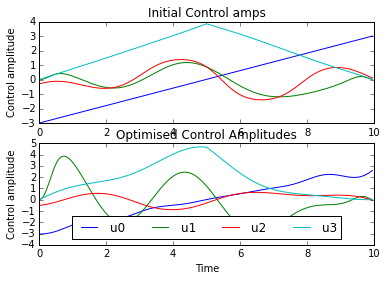

In [12]:
t = result.time[:n_ts]

fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    amps = result.initial_amps[:, j]
    ax1.plot(t, amps)

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    amps = result.final_amps[:, j]
    ax2.plot(t, amps, label='u{}'.format(j))
    
ax2.legend(loc=8, ncol=n_ctrls)

plt.show()

### Versions

In [13]:
from qutip.ipynbtools import version_table

version_table()